In [1]:
import cPickle as pickle

import os
import sys

from utilities2014 import *

from itertools import product

import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from enum import Enum

class PolygonType(Enum):
    CLOSED = 'closed'
    OPEN = 'open'
    TEXTURE = 'textured'
    TEXTURE_WITH_CONTOUR = 'texture with contour'
    DIRECTION = 'directionality'

In [3]:
landmark_indices = range(17)
n_landmark = len(landmark_indices)

In [4]:
# atlas_landmark_desc = 'RS141_0001_yuncong_08212015001655'

In [5]:
# with open('/home/yuncong/csd395/landmark_descriptors/%s_landmark_centroid_global_%d.pkl'%(atlas_landmark_desc, lm_ind), 'r') as f:
#     lm_centroid_global = pickle.load(f)

In [6]:
# labeling_name = 'RS141_0001_yuncong_08282015013756'
labeling_name = 'RS141_0004_yuncong_08282015023125'

In [7]:
with open('/home/yuncong/csd395/landmark_descriptors/%s_landmark_centroids_global.pkl'%labeling_name, 'r') as f:
    landmark_centroids_global = pickle.load(f)

In [8]:
dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=5)
dm._load_image()

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [9]:
response_maps_all_rotations = dict([])
landmark_indices = range(13) + range(14,17)
for lm_ind in landmark_indices:
    print lm_ind
    response_maps_all_rotations[lm_ind] = dm.load_pipeline_result('%sResponseMapLmAllRotations%d'%(''.join(labeling_name.split('_')), lm_ind), 'npy')

0
1
2
3
4
5
6
7
8
9
10
11
12
14
15
16


In [10]:
from skimage.feature import peak_local_max

def find_peaks(vs_max, topk=3):
    
    vs_max_smooth = gaussian_filter(vs_max, sigma=10)

    peaks = peak_local_max(vs_max_smooth)
    ypeaks = peaks[:,0]
    xpeaks = peaks[:,1]

    order = np.argsort(vs_max_smooth[ypeaks, xpeaks])[::-1]
    ypeaks = ypeaks[order]
    xpeaks = xpeaks[order]

    return np.array([(x, y, vs_max[y, x]) for y, x in zip(ypeaks, xpeaks)[:topk]])

def find_peaks_all_rotations(vs_max_all_angles, topk=3):
    
    topk_locs = []
    for theta, vs_max in enumerate(vs_max_all_angles):
        topk_locs += map(lambda t: t+(theta,), find_peaks(vs_max, topk))
        
    topk_locs = sorted(topk_locs, key=lambda x: x[2], reverse=True)[:topk]
    
    return topk_locs

In [11]:
image_centroid = np.array((int(dm.image_width/2), int(dm.image_height/2)))
atlas_centroid = np.array((2772, 1385))

xshifts = np.linspace(-400, 400, 100)
yshifts = np.linspace(-400, 400, 100)
angles = np.linspace(-np.pi/4, np.pi/4, 17)

In [12]:
# sample_lms = np.random.choice(range(n_landmark), n_landmark, replace=False)
# sample_lms = [0, 9]
sample_lms = landmark_indices

In [13]:
def rigid_transform_to(pts1, T):
    pts1_trans = np.dot(T, np.column_stack([pts1, np.ones((pts1.shape[0],))]).T).T
    pts1_trans = pts1_trans[:,:2]/pts1_trans[:,-1][:,np.newaxis]
    return pts1_trans

In [14]:
thetas = np.linspace(-np.pi/4, np.pi/4, 9)
n_theta = len(thetas)

In [15]:
X = [landmark_centroids_global[i] for i in sample_lms]
Xc = X - atlas_centroid
probs = []
for xshift, yshift, angle in product(xshifts, yshifts, angles):
#     print xshift, yshift, angle
    T = np.array([[np.cos(angle), -np.sin(angle), xshift],
                    [np.sin(angle), np.cos(angle), yshift],
                    [0, 0, 1.]])
    TXc = rigid_transform_to(Xc, T).astype(np.int)
    TX = TXc + image_centroid
    
    theta_i = np.argmin(np.abs(thetas - angle))
    
    prob = np.sum(response_maps_all_rotations[lm][theta_i][TX[i,1], TX[i,0]] if TX[i,1] < dm.image_height and TX[i,1] >= 0 \
                                                        and TX[i,0] < dm.image_width and TX[i,0] >= 0\
                  else 0
                  for i, lm in enumerate(sample_lms))
    probs.append(prob)
    
probs_map = np.reshape(probs, (len(xshifts), len(yshifts), len(angles)))

In [74]:
xshift_opt_ind, yshift_opt_ind, rot_opt_ind = np.unravel_index(np.argmax(probs_map), probs_map.shape)
print xshift_opt_ind, yshift_opt_ind, rot_opt_ind

xshift_opt = xshifts[xshift_opt_ind]
yshift_opt = yshifts[yshift_opt_ind]
rot_opt = angles[rot_opt_ind]

print xshift_opt, yshift_opt, rot_opt, np.rad2deg(rot_opt)

theta_i_opt = np.argmin(np.abs(thetas - rot_opt))

print theta_i_opt

57 52 8
60.6060606061 20.202020202 0.0 0.0
4


In [75]:
R = np.array([[np.cos(rot_opt), -np.sin(rot_opt)],
              [np.sin(rot_opt), np.cos(rot_opt)]])

shift = image_centroid + (xshift_opt, yshift_opt) - np.dot(R, atlas_centroid)
T = np.vstack([np.column_stack([R, shift]), [0,0,1]])

In [76]:
# dm.save_pipeline_result(T, 'T', 'npy')

In [77]:
origin_pos_canvas_atlas = np.load(os.environ['GORDON_RESULT_DIR'] + '/atlas_origin_on_canvas.npy')
origin_pos_canvas = dm.load_pipeline_result('originPosOnCanvas', 'npy')
canvas_shape = np.load(os.environ['GORDON_RESULT_DIR'] + '/paddedSize.npy')

shift_padded = image_centroid + (xshift_opt, yshift_opt) + origin_pos_canvas - np.dot(R, atlas_centroid + origin_pos_canvas_atlas)
T_padded = np.vstack([np.column_stack([R, shift_padded]), [0,0,1]])

# image = dm.load_pipeline_result('padded', 'jpg')
# from skimage.transform import warp, AffineTransform
# # image_warpped_to_atlas = warp(image, inverse_map=AffineTransform(T_padded))
# # display(image_warpped_to_atlas)

In [23]:
dm.save_pipeline_result(T_padded, 'Tpadded', 'npy')

saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0004/RS141_x5_0004_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_Tpadded.npy


In [78]:
with open('/home/yuncong/csd395/landmark_descriptors/%s_landmark_vertices_global.pkl'%labeling_name, 'r') as f:
    landmark_vertices_global = pickle.load(f)
    landmark_vertices_global = dict([(i, np.vstack([vs for vs in vss if len(vs) > 0]).astype(np.int))
                                for i, vss in landmark_vertices_global.iteritems()])

In [79]:
with open('/home/yuncong/csd395/landmark_descriptors/%s_landmark_polygon_vertices_global.pkl'%labeling_name, 'r') as f:
    landmark_polygon_vertices_global = pickle.load(f)
    landmark_polygon_vertices_global = dict([(i, [(t, vs.astype(np.int)) for t,vs in polygons]) for i, polygons in landmark_polygon_vertices_global.iteritems()])

In [80]:
atlas_grids = np.load(os.environ['GORDON_RESULT_DIR'] + '/atlas_grids.npy')

In [81]:
colors = (np.loadtxt(os.environ['GORDON_REPO_DIR'] + '/visualization/100colors.txt', skiprows=1) * 255).astype(np.int)

In [82]:
atlas_viz = img_as_ubyte(dm.image_rgb)

for x,y in landmark_centroids_global.itervalues():
    cv2.circle(atlas_viz, (x,y), 20, colors[i], -1)
    
for x,y in atlas_grids:
    cv2.circle(atlas_viz, (x,y), 1, (0,0,0), -1)

for i, lm in landmark_polygon_vertices_global.iteritems():
    for ptype, vs in lm:
#         for x, y in vs.astype(np.int):
#             cv2.circle(atlas_viz, (x,y), 10, colors[i], -1)

        if ptype == PolygonType.OPEN or ptype == PolygonType.DIRECTION:
            cv2.polylines(atlas_viz, [vs.astype(np.int)], False, colors[i], 5)
        else:
            cv2.polylines(atlas_viz, [vs.astype(np.int)], True, colors[i], 5)

# dm.save_pipeline_result(atlas_viz, 'atlasViz', 'jpg')
display(atlas_viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [83]:
global_transf_vertices = dict([(i, rigid_transform_to(vs, T).astype(np.int))
                               for i, vs in landmark_vertices_global.iteritems()])

global_transf_polygon_vertices = dict([(i, [(ptype, rigid_transform_to(vs, T).astype(np.int)) 
                                            for ptype, vs in polygon_vs])
                                  for i, polygon_vs in landmark_polygon_vertices_global.iteritems()])

global_transf_centroids = dict([(lm_ind, np.squeeze(rigid_transform_to(landmark_centroids_global[lm_ind][None,:], T).astype(np.int))) 
                        for lm_ind in landmark_indices])

global_transf_grids = rigid_transform_to(atlas_grids, T).astype(np.int)

In [84]:
global_tranf_atlas_viz = img_as_ubyte(dm.image_rgb)

for x,y in global_transf_grids:
    cv2.circle(global_tranf_atlas_viz, (x,y), 1, (0,0,0), -1)

for i, (x,y) in global_transf_centroids.iteritems():
    cv2.circle(global_tranf_atlas_viz, (x,y), 20, colors[i], -1)

for i, lm in global_transf_polygon_vertices.iteritems():
    for ptype, vs in lm:
#         for x, y in vs:
#             cv2.circle(global_tranf_atlas_viz, (x,y), 10, colors[i], -1)
        if ptype == PolygonType.OPEN or ptype == PolygonType.DIRECTION:
            cv2.polylines(global_tranf_atlas_viz, [vs], False, colors[i], 5)
        else:
            cv2.polylines(global_tranf_atlas_viz, [vs], True, colors[i], 5)

# dm.save_pipeline_result(global_tranf_atlas_viz, 'globalTransfAtlasViz', 'jpg')
display(global_tranf_atlas_viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [31]:
# dm.save_pipeline_result(new_centroids_global, 'landmarkPositionsBeforeSnap', 'npy')

In [87]:
displacement_control_points_dict = []
control_points_dict = []

for lm_ind in landmark_indices:
    print lm_ind

    centroid = global_transf_centroids[lm_ind]
    
    rmap = response_maps_all_rotations[lm_ind][theta_i_opt]

    peaks = find_peaks(rmap, topk=-1)[:,:2].astype(np.int)
    dists = np.squeeze(cdist([centroid], peaks))
    peak_indices_in_neighborhood = np.where(dists < 300)[0]
#     if len(peak_indices_in_neighborhood) == 0:
#         nearest_peak = new_centroid_global
#     else:
    if len(peak_indices_in_neighborhood) > 0:
        peak_scores = rmap[peaks[peak_indices_in_neighborhood,1], peaks[peak_indices_in_neighborhood,0]]
        nearest_peak = peaks[peak_indices_in_neighborhood[np.argmax(peak_scores)]]

    control_points_dict.append((lm_ind, centroid))
    displacement_control_points_dict.append((lm_ind, nearest_peak - centroid))

control_points = dict(control_points_dict)
displacement_control_points = dict(displacement_control_points_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
14
15
16


In [33]:
dm.save_pipeline_result(control_points, 'controlPoints', 'npy')
dm.save_pipeline_result(displacement_control_points, 'controlPointsDisplacement', 'npy')

saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0004/RS141_x5_0004_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_controlPoints.npy
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0004/RS141_x5_0004_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_controlPointsDisplacement.npy


In [90]:
control_points_viz = img_as_ubyte(dm.image_rgb)

for i in control_points.iterkeys():

    x0, y0 = control_points[i]
    x, y = control_points[i] + displacement_control_points[i]
    
# for (x0,y0), (x,y) in zip(control_points, (control_points + displacement_control_points)):
    cv2.circle(control_points_viz, (x0,y0), 20, (0,255,0), -1)
    cv2.circle(control_points_viz, (x,y), 20, colors[i], -1)
    cv2.line(control_points_viz, (x0,y0), (x,y), colors[i], 5)
    
for i, lm in global_transf_polygon_vertices.iteritems():
    for ptype, vs in lm:
#         for x, y in vs:
#             cv2.circle(global_tranf_atlas_viz, (x,y), 10, colors[i], -1)
        if ptype == PolygonType.OPEN or ptype == PolygonType.DIRECTION:
            cv2.polylines(control_points_viz, [vs + displacement_control_points[i]], False, colors[i], 5)
        else:
            cv2.polylines(control_points_viz, [vs + displacement_control_points[i]], True, colors[i], 5)
    
display(control_points_viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [89]:
# snapped_vertices = dict([(i, vs + displacement_control_points[i])
#                                for i, vs in global_transf_vertices.iteritems()])

# snapped_polygon_vertices = dict([(i, [(ptype, vs + displacement_control_points[i]) 
#                                       for ptype, vs in polygon_vs])
#                                   for i, polygon_vs in global_transf_polygon_vertices.iteritems()])

# snapped_centroids = dict([(i, (pt + displacement_control_points[i]).astype(np.int))
#                         for i, pt in global_transf_centroids.iteritems()])

In [38]:
def interpolate_displacement(pts, control_points, displacement_control_points, rbf_sigma=500):
    diffs = np.array([p - control_points for p in pts])
    dists_control_points = np.sqrt(np.sum(diffs**2, axis=-1))
    weights_control_points = np.exp(-dists_control_points**2/rbf_sigma**2)
    weights_control_points = weights_control_points / np.sum(weights_control_points, axis=1)[:,None]

    pts_displacements = np.dot(weights_control_points, displacement_control_points)
    displaced_pts = pts + pts_displacements
    
    return displaced_pts

In [39]:
rbf_sigma = 500

In [50]:
displacement_transf_grids = interpolate_displacement(global_transf_grids,
                        control_points, displacement_control_points, rbf_sigma=rbf_sigma).astype(np.int)

displacement_transf_centroids = dict([(i, interpolate_displacement([pt],
                               control_points, displacement_control_points, rbf_sigma=rbf_sigma)[0].astype(np.int))
                                      for i, pt in global_transf_centroids.iteritems()])


displacement_transf_vertices = dict([(i, interpolate_displacement(vs,
                                 control_points, displacement_control_points, rbf_sigma=rbf_sigma).astype(np.int))
                                for i, vs in global_transf_vertices.iteritems()])

displacement_transf_polygon_vertices = dict([(i, [(ptype, interpolate_displacement(vs,
                               control_points, displacement_control_points, rbf_sigma=rbf_sigma).astype(np.int)) 
                                                  for ptype, vs in polygon_vs])
                                             for i, polygon_vs in global_transf_polygon_vertices.iteritems()])

In [51]:
displacement_transf_atlas_viz = img_as_ubyte(dm.image_rgb)

displacement_transf_grids_valid = np.minimum((dm.image_width-1, dm.image_height-1), np.maximum(displacement_transf_grids, (0,0)))

for x,y in displacement_transf_grids_valid:
    cv2.circle(displacement_transf_atlas_viz, (x,y), 1, (0,0,0), -1)
    
for i, (x,y) in displacement_transf_centroids.iteritems():
    cv2.circle(displacement_transf_atlas_viz, (x,y), 20, (0,255,0), -1)
    
for i, lm in displacement_transf_polygon_vertices.iteritems():
    for ptype, vs in lm:
#         for x, y in vs:
#             cv2.circle(displacement_transf_atlas_viz, (x,y), 10, colors[i], -1)
        
        if ptype == PolygonType.OPEN or ptype == PolygonType.DIRECTION:
            cv2.polylines(displacement_transf_atlas_viz, [vs], False, colors[i], 5)
        else:
            cv2.polylines(displacement_transf_atlas_viz, [vs], True, colors[i], 5)

# dm.save_pipeline_result(displacement_transf_atlas_viz, 'displacementTransfAtlasViz', 'jpg')
display(displacement_transf_atlas_viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [38]:
import datetime

with open(os.environ['GORDON_LABELING_DIR']+'/RS141/0001/RS141_0001_yuncong_08212015001655.pkl', 'r') as f:
    labelings = pickle.load(f)

new_labeling = dict([])
new_labeling['parent_labeling_name'] = None
new_labeling['login_time'] = None
new_labeling['initial_polygons'] = None
new_labeling['labelnames'] = labelings['labelnames']
new_labeling['logout_time'] = datetime.datetime.now().strftime("%m%d%Y%H%M%S")
new_labeling['final_polygons'] = displacement_transf_polygon_vertices
new_labeling['username'] = 'hector'

new_labeling_name = new_labeling['username'] + '_' + new_labeling['logout_time']

In [41]:
dm.save_labeling(new_labeling, new_labeling_name, displacement_transf_atlas_viz)

Labeling saved to /oasis/projects/nsf/csd181/yuncong/DavidData2014labelings/RS141/0004/RS141_0004_hector_08282015020427.pkl
Preview saved to /oasis/projects/nsf/csd181/yuncong/DavidData2014labelings/RS141/0004/RS141_0004_hector_08282015020427.jpg


'/oasis/projects/nsf/csd181/yuncong/DavidData2014labelings/RS141/0004/RS141_0004_hector_08282015020427.pkl'

In [53]:
# def move_landmark(lm_ind, snap_peak=True):
    
#     with open('/home/yuncong/csd395/landmark_descriptors/%s_landmark_boundary_vertices_all_polygons_global_%d.pkl'%(atlas_landmark_desc, lm_ind), 'r') as f:
#         all_polygon_boundary_vertices = pickle.load(f)[theta_i_opt]
        
#     with open('/home/yuncong/csd395/landmark_descriptors/%s_landmark_textured_area_vertices_all_polygons_global_%d.pkl'%(atlas_landmark_desc, lm_ind), 'r') as f:
#         all_polygon_textured_area_vertices = pickle.load(f)[theta_i_opt]

#     with open('/home/yuncong/csd395/landmark_descriptors/%s_landmark_striation_points_all_polygons_global_%d.pkl'%(atlas_landmark_desc, lm_ind), 'r') as f:
#         all_polygon_striation_vertices = pickle.load(f)[theta_i_opt]

#     new_centroid_global = new_centroids_global[lm_ind]

#     new_landmark_descriptor = dict([])
#     new_landmark_descriptor['bbox'] = np.nan * np.ones((10,))
#     new_landmark_descriptor['bbox'][4:6] = new_centroid_global

#     if snap_peak:
    
#         peaks = find_peaks(response_maps_all_rotations[lm_ind][theta_i_opt], topk=-1)[:,:2].astype(np.int)
#         dists = np.squeeze(cdist([new_centroid_global], peaks))
#         peak_indices_in_neighborhood = np.where(dists < 200)[0]
#         if len(peak_indices_in_neighborhood) == 0:
#             nearest_peak = new_centroid_global
#         else:

#         #     peak_scores = np.exp(-dists[peak_indices_in_neighborhood]**2/10**2) * \
#         #             response_maps_all_rotations[lm_ind][theta_i_opt][peaks[peak_indices_in_neighborhood,1],
#         #                                                             peaks[peak_indices_in_neighborhood,0]]

#             peak_scores = response_maps_all_rotations[lm_ind][theta_i_opt][peaks[peak_indices_in_neighborhood,1],
#                                                                     peaks[peak_indices_in_neighborhood,0]]
#             nearest_peak = peaks[peak_indices_in_neighborhood[np.argmax(peak_scores)]]
            
#     else:
#         nearest_peak = new_centroid_global

#     if all_polygon_boundary_vertices is not None:
#         new_landmark_descriptor['boundary_vertices_all_polygons_global'] = [rigid_transform_to(v, T).astype(np.int) - new_centroid_global + nearest_peak
#                                                                              for v in all_polygon_boundary_vertices]
#     else:
#         new_landmark_descriptor['boundary_vertices_all_polygons_global'] = None

#     if all_polygon_textured_area_vertices is not None:
#         new_landmark_descriptor['textured_area_vertices_all_polygons_global'] = [rigid_transform_to(v, T).astype(np.int) - new_centroid_global + nearest_peak
#                                                                                   for v in all_polygon_textured_area_vertices]
#     else:
#         new_landmark_descriptor['textured_area_vertices_all_polygons_global'] = None

#     if all_polygon_striation_vertices is not None:
#         new_landmark_descriptor['striation_vertices_all_polygons_global'] = [rigid_transform_to(v, T).astype(np.int) - new_centroid_global + nearest_peak
#                                                                               for v in all_polygon_striation_vertices]
#     else:
#         new_landmark_descriptor['striation_vertices_all_polygons_global'] = None

#     return new_landmark_descriptor

In [21]:
# from joblib import Parallel, delayed

In [55]:
# new_landmark_descriptors = Parallel(n_jobs=16)(delayed(move_landmark)(lm_ind, snap_peak=False) 
#                                                for lm_ind in landmark_indices)
# new_landmark_descriptors = dict(zip(landmark_indices, new_landmark_descriptors))

In [67]:
# import datetime
# timestamp = datetime.datetime.now().strftime("%m%d%Y%H%M%S")

# for lm_ind in landmark_indices:
#     with open('/home/yuncong/csd395/%s_%s_%s_%s_landmark_descriptors_%d.pkl'%(
#             dm.stack, dm.slice_str, 'hector', timestamp, lm_ind), 'w') as f:
#         pickle.dump(new_landmark_descriptors[lm_ind], f)

In [43]:
# dm.save_pipeline_result(viz, 'landmarkDetections', 'jpg')

saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0004/RS141_x5_0004_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_landmarkDetections.jpg


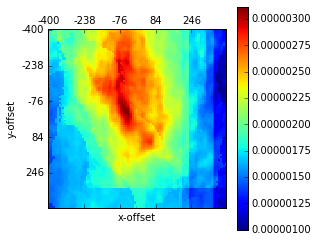

In [39]:
plt.matshow(probs_map[:,:,rot_opt_ind]);
plt.xticks(range(0, len(xshifts), 20), xshifts[::20].astype(np.int));
plt.xlabel('x-offset');
plt.yticks(range(0, len(yshifts), 20), yshifts[::20].astype(np.int));
plt.ylabel('y-offset');
plt.colorbar();

In [29]:
origin_pos_canvas_atlas = np.load(os.environ['GORDON_RESULT_DIR'] + '/atlas_origin_on_canvas.npy')
origin_pos_canvas = dm.load_pipeline_result('originPosOnCanvas', 'npy')

In [21]:
canvas_shape = np.load(os.environ['GORDON_RESULT_DIR'] + '/paddedSize.npy')

In [61]:
def alpha_blending(src_rgb, dst_rgb, src_alpha, dst_alpha):
    
    
    if np.issubdtype(src_rgb.dtype, np.uint8):
        img = img_as_float(img)
    
    if src_rgb.dtype == np.uint8:
        src_rgb = img_as_float(src_rgb)

    if dst_rgb.dtype == np.uint8:
        dst_rgb = img_as_float(dst_rgb)
        
    if isinstance(src_alpha, float) or  isinstance(src_alpha, int):
        src_alpha = src_alpha * np.ones((src_rgb.shape[0], src_rgb.shape[1]))

    if isinstance(dst_alpha, float) or  isinstance(dst_alpha, int):
        dst_alpha = dst_alpha * np.ones((dst_rgb.shape[0], dst_rgb.shape[1]))

    out_alpha = src_alpha + dst_alpha * (1. - src_alpha)
    out_rgb = (src_rgb * src_alpha[..., None] +
               dst_rgb * dst_alpha[..., None] * (1. - src_alpha[..., None])) / out_alpha[..., None]
    
    out = np.zeros((src_rgb.shape[0], src_rgb.shape[1], 4))
        
    out[..., :3] = out_rgb
    out[..., 3] = out_alpha
    
    return out

In [63]:
from skimage.transform import warp, AffineTransform

R = np.array([[np.cos(rot_opt), -np.sin(rot_opt)],
                [np.sin(rot_opt), np.cos(rot_opt)]])

shift_padded = image_centroid + (xshift_opt, yshift_opt) + origin_pos_canvas - np.dot(R, atlas_centroid + origin_pos_canvas_atlas)
T_padded = np.vstack([np.column_stack([R, shift_padded]), [0,0,1]])

image = dm.load_pipeline_result('padded', 'jpg')
# image_warpped_to_atlas = warp(image, inverse_map=AffineTransform(T_padded))
# display(image_warpped_to_atlas)

In [59]:
display(atlas_warpped_to_image)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [64]:
atlas_warpped_to_image = warp(atlas_viz, inverse_map=AffineTransform(T_padded).inverse)
# display(atlas_warpped_to_image)

overlayed = alpha_blending(atlas_warpped_to_image, image, .3, .7)
display(overlayed)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [37]:
atlas_viz = imread(os.environ['GORDON_RESULT_DIR']+'/atlas_viz.jpg')

In [65]:
display(atlas_viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [47]:
overlayed = alpha_blending(img_as_float(canvas2_warpped_to_atlas), img_as_float(atlas_viz), .5, .5)
display(overlayed)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg